In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 

# Bonus vector manipulation
import pandas as pd
#from pandas import Dataframe
import geopandas as gpd
from shapely import wkt
from datetime import datetime

CMAP = "Blues"

# Land Change

This notebook uses changes in NDVI, EVI or Fractional Cover to identify land change. The algorithm identifies a "baseline" and "analysis" time period and then compares the spectral parameters in each of those time periods. Significant reductions in vegetation are coincident with land change. In some cases these changes could be deforestation. Users of this algorithm should not accept the accuracy of the results but should conduct ground validation testing to assess accuracy. In most cases, these algorithms can be used to identify clusters of pixels that have experienced change and allow targeted investigation of those areas by local or regional governments.

In [2]:
# Load Data Cube Configuration
import datacube
dc = datacube.Datacube(app = 'land_degredation')#, config = '/home/localuser/.datacube.conf')

# Import Data Cube API
import utils_dcal.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()#config = '/home/localuser/.datacube.conf')
dc = api.dc

from utils_dcal.data_cube_utilities.dc_display_map import display_map
from utils_sac.createAOI import create_lat_lon
from utils_sac.createindices import NDVI, EVI
from utils_sac.clean_mask import landsat_qa_clean_mask
from utils_sac.dc_mosaic import create_max_ndvi_mosaic, create_min_ndvi_mosaic, create_median_mosaic, create_mosaic, create_hdmedians_multiple_band_mosaic
#from utils_dcal.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_min_ndvi_mosaic, create_median_mosaic, create_mosaic, create_hdmedians_multiple_band_mosaic
from deaAfricascripts.deafrica_plotting import rgb
#if S2
#from utils_sac.fractional_cover import frac_coverage_classify
#if L8
from utils_dcal.data_cube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
import matplotlib.pyplot as plt
from matplotlib.cm import RdYlGn, Greens
from utils_sac.fromDCALscripts import threshold_plot


In [3]:
# CHANGE HERE >>>>>>>>>>>>>>>>>

# Select a Product and Platform

#product = 's2_esa_sr_granule'
#platform = "SENTINEL_2"
#measurements = ["green","red","blue","nir","swir_1","swir_2","coastal_aerosol","scene_classification"]

product = 'ls8_usgs_sr_scene'
platform = "LANDSAT_8"
measurements = ["red", "green", "blue", "nir", "swir1", "swir2", "pixel_qa"]

output_crs = "EPSG:32760"
resolution = (-30, 30)

In [4]:
#central area - do dates 2013- 2014 and 2018-2019
aoi_wkt = "POLYGON ((177.42576599121094 -18.058395415674948, 177.5390625 -18.058395415674948, 177.5390625 -17.96567026450931, 177.42576599121094 -17.96567026450931, 177.42576599121094 -18.058395415674948))"
# wakaya island - hit by cyclone winston in feb 2016  - dates end of JAn 2015-2016, start of March 2016 - 2017
#aoi_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"

In [5]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [6]:
## The code below renders a map that can be used to orient yourself with the region.

display_map(latitude = lat_extents, longitude = lon_extents)

# Define Analysis Parameters 

In [7]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>>>

# Select the start and end periods for your analysis products
# The datetime function is (Year,Month,Day)
# These time windows will be used to make a mosaic, so typically pick a year length or more
# Be sure to evaluate the RGB mosaics to affirm they are not full of clouds

# Select the baseline time period (start and end)
#baseline_time_period = (datetime(2015,1,30), datetime(2016,1,30))
baseline_time_period = (datetime(2019,1,1), datetime(2019,3,1))

# Select the analysis time period (start and end)
analysis_time_period = (datetime(2019,3,1), datetime(2019,5,1))


In [8]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

# Select the cloud-free mosaic type
# Options are: max_ndvi, min_ndvi, median, most_recent_pixel, geomedian
# If a geomedian is selected, it will take much longer to process
# It is most common to use the max_ndvi or median for these land change analyses
# HINT: Consider max_ndvi mosaics for NDVI analyses and median mosaics for EVI analyses 

mosaic_type = "max_ndvi" 



# Load and Clean Data

>#### Load Data ( Baseline, Analysis) 

In [9]:
baseline_ds = dc.load(
    latitude = lat_extents,
    longitude = lon_extents,
    time = baseline_time_period,
    measurements = measurements,
    product = product,
    platform = platform,                         
    output_crs = output_crs,
    resolution = resolution
)


In [10]:
analysis_ds = dc.load(
    latitude = lat_extents,
    longitude = lon_extents,
    time = analysis_time_period,
    measurements = measurements,
    product = product,
    platform = platform,                         
    output_crs = output_crs,
    resolution = resolution
)

> #### Check if loads are valid

In [11]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [12]:
if is_dataset_empty(baseline_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

In [13]:
if is_dataset_empty(analysis_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Analysis Dataset!")

In [14]:
##comment out for L8
#baseline_ds['swir1']=baseline_ds.swir_1
#baseline_ds['swir2']=baseline_ds.swir_2
#baseline_ds = baseline_ds.drop('swir_1')
#baseline_ds = baseline_ds.drop('swir_2')
#analysis_ds['swir1']=analysis_ds.swir_1
#analysis_ds['swir2']=analysis_ds.swir_2
#analysis_ds = analysis_ds.drop('swir_1')
#analysis_ds = analysis_ds.drop('swir_2')

> #### Clean Data
> Generating boolean masks that highlight valid pixels
> Pixels must be cloud-free over land or water to be considered

In [15]:
#create cloud mask
baseline_clean_mask = landsat_qa_clean_mask(baseline_ds, platform)
analysis_clean_mask = landsat_qa_clean_mask(analysis_ds, platform)

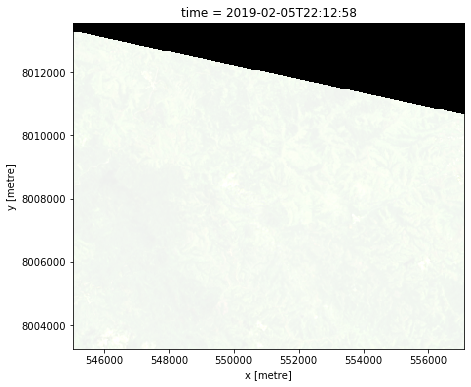

In [16]:
test = baseline_ds.isel(time = 11)
rgb(test)

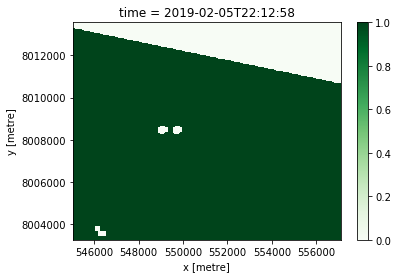

In [17]:
baseline_clean_mask.isel(time = 11).plot(cmap='Greens');

In [18]:
#mask products
baseline_ds_masked = baseline_ds.where(baseline_clean_mask)
analysis_ds_masked = analysis_ds.where(analysis_clean_mask)

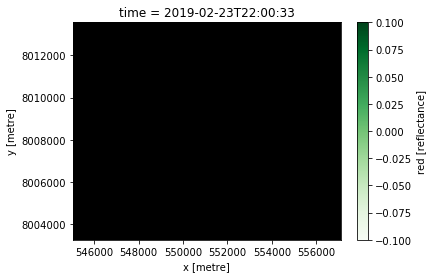

In [149]:
#test2 = baseline_ds_masked.isel(time = 11)
#rgb(test2)
baseline_ds_masked.red.isel(time = 18).plot(cmap='Greens');

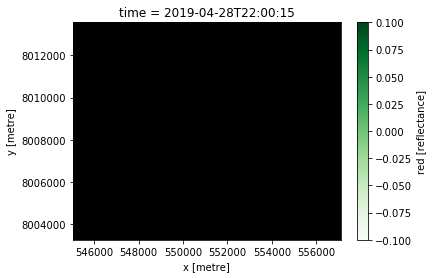

In [153]:
analysis_ds_masked.red.isel(time = 19).plot(cmap='Greens');

>#### Mosaic
> Use clean masks in a time series composite

In [20]:
mosaic_function = {"median": create_median_mosaic,
                   "max_ndvi": create_max_ndvi_mosaic,
                   "min_ndvi": create_min_ndvi_mosaic,
                   "geomedian": create_hdmedians_multiple_band_mosaic,
                   "most_recent_pixel": create_mosaic}

In [21]:
new_compositor = mosaic_function[mosaic_type]


In [105]:
baseline_composite = new_compositor(baseline_ds_masked, clean_mask = baseline_clean_mask)
analysis_composite = new_compositor(analysis_ds_masked, clean_mask = analysis_clean_mask)
#clean_mask = np.ones(baseline_composite.pixel_qa.shape).astype(np.bool)
#baseline_composite = new_compositor(baseline_ds_masked)
#analysis_composite = new_compositor(analysis_ds_masked)

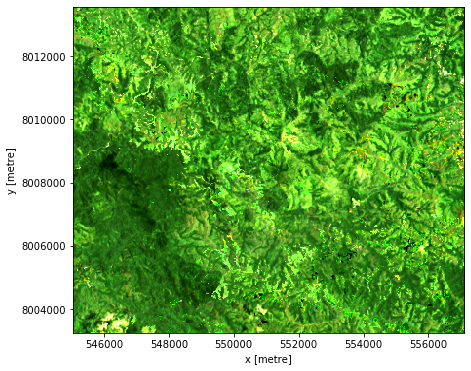

In [106]:
rgb(baseline_composite)

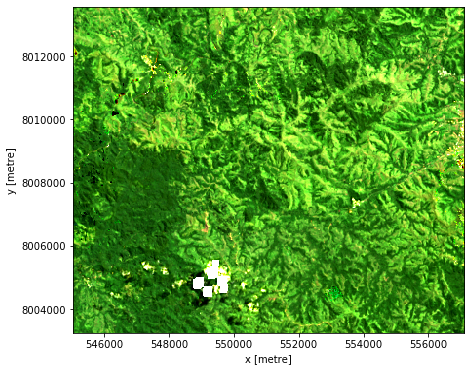

In [107]:
rgb(analysis_composite)

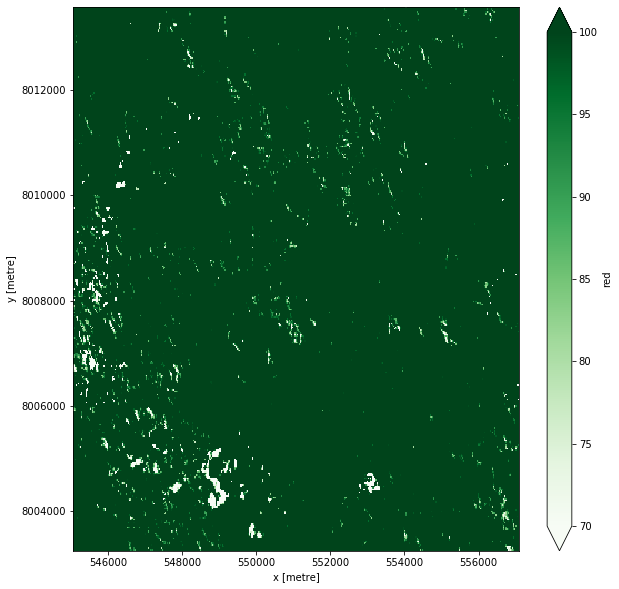

In [108]:
(analysis_composite.red).plot(figsize=(10,10),cmap = "Greens", vmin=70.0, vmax=100.0)

>## Plot a spectral index using the cloud-filtered mosaic

In [109]:
ndvi = NDVI(baseline_composite) 
evi = EVI(baseline_composite)

In [110]:
baseline_composite = baseline_composite.rename({"y": "latitude", "x":"longitude"})
analysis_composite = analysis_composite.rename({"y": "latitude", "x":"longitude"})
#frac_classes = frac_coverage_classify(baseline_composite, clean_mask = baseline_clean_mask) 
frac_classes = frac_coverage_classify(baseline_composite, clean_mask = np.ones(baseline_composite.pixel_qa.shape).astype(np.bool))
#frac_classes = frac_coverage_classify(baseline_composite)

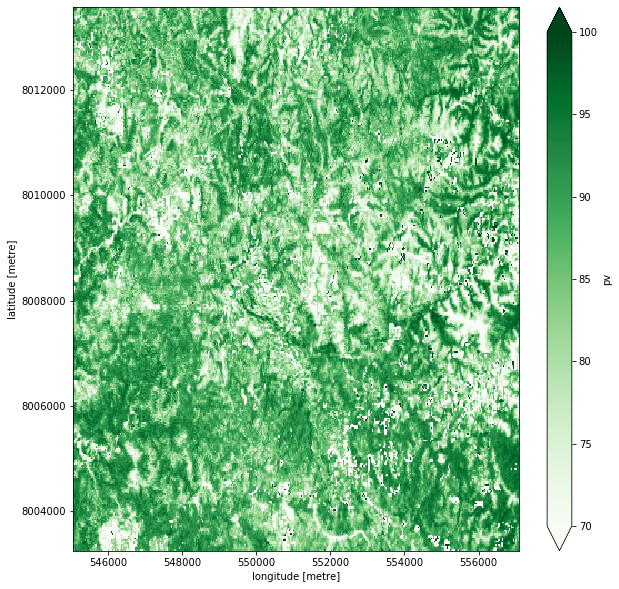

In [111]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>

# Select a spectral index to plot by removing one of the comment tags (#) below
# Adjust the scale of the output using vmin and vmax

# (ndvi).plot(figsize=(10,10),cmap = "Greens", vmin=0.3, vmax=1.0)
#(evi).plot(figsize=(10,10),cmap = "Greens", vmin=1.75, vmax=2.5)
(frac_classes.pv).plot(figsize=(10,10),cmap = "Greens", vmin=70.0, vmax=100.0)

In [112]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>>>

# Select a baseline threshold range for a given parameter ... which is basically a "mask"
# The analysis will only consider pixels in this range for change detection
# No data or cloud pixels will also be masked in this process

# If you want to see all change, you should select the full range of values for each parameter
# NDVI full range = 0.0 to 1.0
# EVI full range = 0.0 to 2.5
# Fractional Cover full range = 0.0 to 100.0

# If you want to mask out dense vegetation, typical of forested land, use the values below
# NDVI: 0.7 to 1.0
# EVI: 2.0 to 2.5
# Fractional Cover PV: 70.0 to 100.0
#NDVI
#baseline_threshold_range = (0.7, 1.0)

#EVI
#baseline_threshold_range = (2, 2.5) 

#fractional cover
baseline_threshold_range = (70, 100)


In [113]:
_min, _max = baseline_threshold_range  

In [118]:
# CHANGE HERE >>>>>>>>>>>>>

# Select the parameter to be used for thresholding ... NDVI, EVI or FC
# Remove the comment statement to use the desired parameter

# baseline_filter_mask = np.logical_and(NDVI(baseline_composite) > _min, NDVI(baseline_composite) < _max)    
#baseline_filter_mask = np.logical_and(EVI(baseline_composite) > _min, EVI(baseline_composite) < _max)    
baseline_filter_mask = np.logical_and(frac_classes.pv > _min, frac_classes.pv < _max)    


In [119]:
def aspect_ratio_helper(ds, fixed_width = 12):
        y,x = ds.values.shape
        width = fixed_width
        height = y * (fixed_width / x)
        return (width, height)

In [120]:

RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

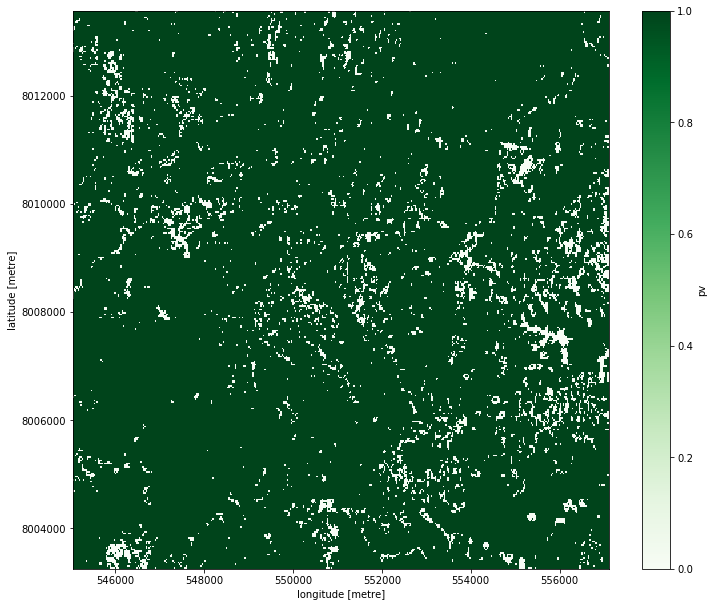

In [121]:
# This is the baseline threshold plot that shows GREEN pixels in the threshold range
# Pixels with values outside the threshold range are white 

plt.figure(figsize = aspect_ratio_helper(baseline_filter_mask)) 
baseline_filter_mask.plot(cmap = "Greens")

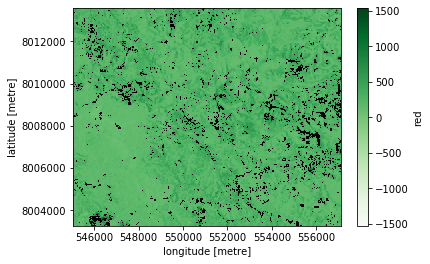

In [122]:
baseline_composite = baseline_composite.where(baseline_filter_mask)
baseline_composite.red.plot(cmap = "Greens")

# Spectral Parameter Anomaly

In [123]:
#from utils_dcal.data_cube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
#from utils_sac.fractional_cover import frac_coverage_classify 
#odc-hub/utils_sac/.py

In [124]:
# CHANGE HERE >>>>>>>>>>>>>
# Select the parameter to be used for the analysis
# You will select two lines for each parameter (baseline and analysis)

# Select these two lines for NDVI
# parameter_baseline_composite = NDVI(baseline_composite)
# parameter_analysis_composite = NDVI(analysis_composite)

# Select these two lines for EVI
#parameter_baseline_composite = EVI(baseline_composite)
#parameter_analysis_composite = EVI(analysis_composite)

# Select these two lines for Fractional Cover (FC)
parameter_baseline_composite = frac_coverage_classify(baseline_composite, clean_mask = np.ones(baseline_composite.pixel_qa.shape).astype(np.bool)) 
parameter_analysis_composite = frac_coverage_classify(analysis_composite, clean_mask = np.ones(analysis_composite.pixel_qa.shape).astype(np.bool)) 
#parameter_baseline_composite = frac_coverage_classify(baseline_composite, clean_mask = baseline_clean_mask)
#parameter_analysis_composite = frac_coverage_classify(analysis_composite, clean_mask = analysis_clean_mask) 
#parameter_baseline_composite  = frac_coverage_classify(baseline_composite)
#parameter_analysis_composite  = frac_coverage_classify(analysis_composite)

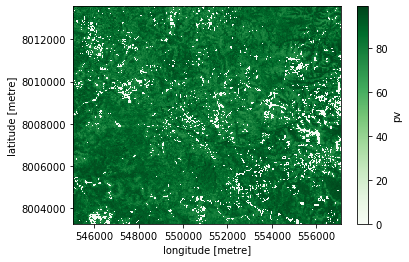

In [125]:
parameter_baseline_composite.pv.plot(cmap = "Greens")

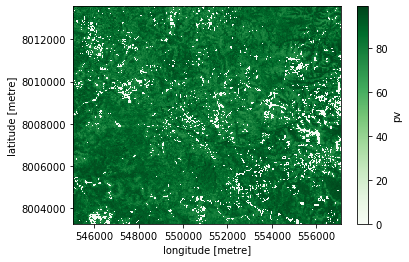

In [126]:
parameter_baseline_composite.pv.plot(cmap = "Greens")

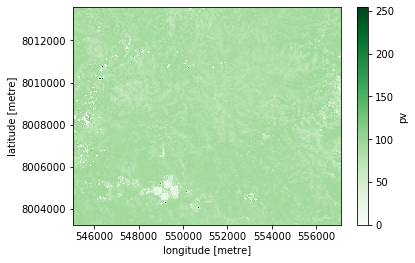

In [127]:
parameter_analysis_composite.pv.plot(cmap = "Greens")

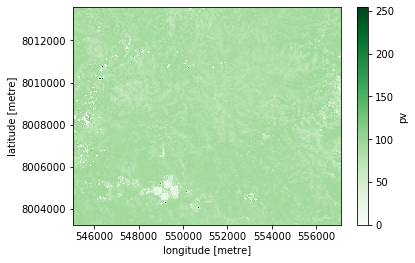

In [128]:
parameter_analysis_composite.pv.plot(cmap = "Greens")

In [129]:
# CHANGE HERE >>>>>>>>>>>>>

# Select this line for NDVI or EVI
#parameter_anomaly = parameter_analysis_composite - parameter_baseline_composite

# Select this line for Fractional Cover (FC), where PV = Photosynthetic Vegetation
parameter_anomaly = parameter_analysis_composite.pv - parameter_baseline_composite.pv

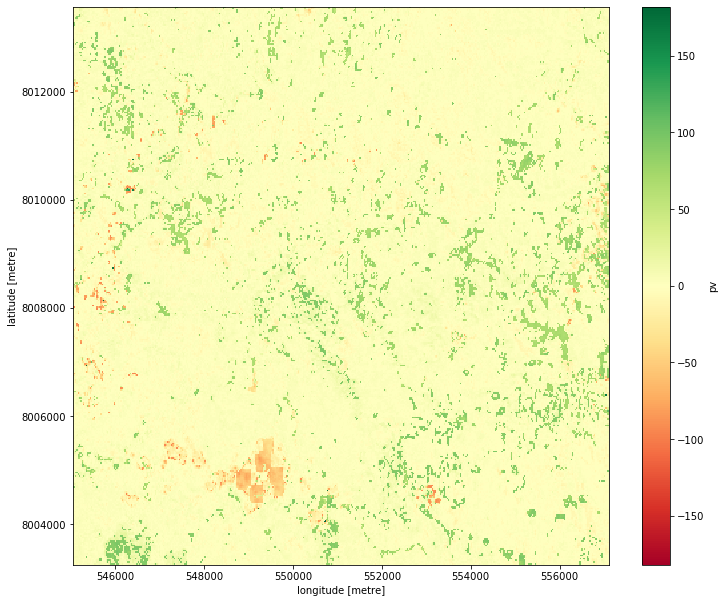

In [130]:
# Plot the parameter change from the baseline to the analysis period
# Significant loss in vegetation will be shown in RED
# Gains in vegetation will be shown in GREEN

plt.figure(figsize = aspect_ratio_helper(parameter_anomaly)) 
parameter_anomaly.plot(cmap = RdYlGn)

# Anomaly Threshold Product

In [131]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>>>

# Select an Anomaly Threshold Range to filter the results from the previous image
# Be sure to put the smallest value in the "minimum_change" location (be careful of negative values)

# Losses are typically in these ranges for deforestation

#NDVI
#minimum_change = -0.7
#maximum_change = -0.2

#EVI
#minimum_change = -1.75
#maximum_change = -0.5

# Fractional Cover PV: -20 to -70
minimum_change = -70
maximum_change = -20

In [132]:
# Create a threshold plot using the MIN and MAX range defined above


In [144]:
#no_data_mask = np.logical_or(np.isnan(baseline_composite.red.values), np.isnan(analysis_composite.red.values))
no_data_mask = np.logical_or(np.isnan(baseline_clean_mask.values), np.isnan(analysis_clean_mask.values)) 


ValueError: operands could not be broadcast together with shapes (19,344,402) (20,344,402) 

In [141]:
# Plot the parameter change using thresholds and 3 colors 
# RED = data in the threshold range (significant land change)
# BLACK = data outside the threshold range (no significant change)
# WHITE = data outside the baseline mask (not dense vegetation) or clouds (no data)
#parameter_anomaly = parameter_anomaly.rename({"x":"latitude", "y":"longitude"})
threshold_plot(parameter_anomaly, minimum_change, maximum_change, mask = no_data_mask, width  = 10)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 344 but corresponding boolean dimension is 19

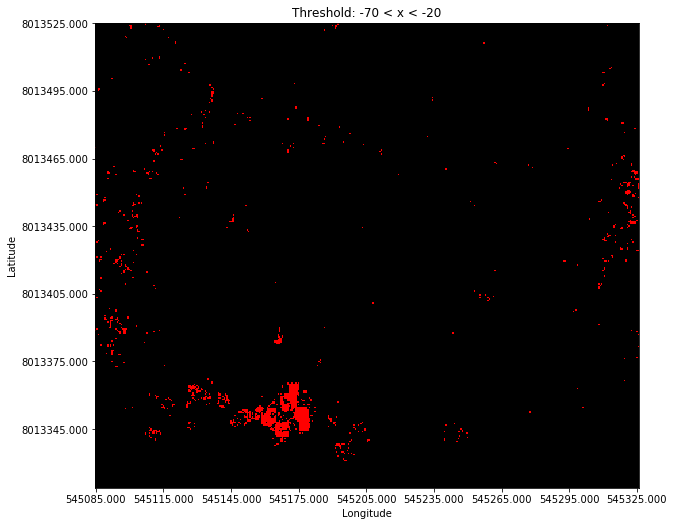

In [135]:
threshold_plot(parameter_anomaly, minimum_change, maximum_change, width  = 10)

In [ ]:
def threshold_count(da, min_threshold, max_threshold, mask = None):
    def count_not_nans(arr):
        return np.count_nonzero(~np.isnan(arr))
    
    in_threshold = np.logical_and( da.values > min_threshold, da.values < max_threshold)
    
    total_non_cloudy = count_not_nans(da.values) if mask is None else np.sum(mask) 
    
    return dict(total = np.size(da.values),
                total_non_cloudy = total_non_cloudy,
                inside = np.nansum(in_threshold),
                outside = total_non_cloudy - np.nansum(in_threshold)
               )    
    
def threshold_percentage(da, min_threshold, max_threshold, mask = None):
    counts = threshold_count(da, min_threshold, max_threshold, mask = mask)
    return dict(percent_inside_threshold = (counts["inside"]   / counts["total"]) * 100.0,
                percent_outside_threshold = (counts["outside"] / counts["total"]) * 100.0,
                percent_clouds = ( 100.0-counts["total_non_cloudy"] / counts["total"] * 100.0))


In [ ]:
# This output is a count of the pixels that fall within each threshold range

threshold_count(parameter_anomaly,minimum_change,maximum_change)

In [ ]:
# This output is a percentage of the pixels that fall within each threshold range

threshold_percentage(parameter_anomaly,minimum_change,maximum_change)

## GeoTIFF Output Products

In [ ]:
import rasterio

def write_geotiff_from_xr(tif_path, data, bands=None, no_data=-9999, crs="EPSG:4326",
                          x_coord='longitude', y_coord='latitude'):
    """Write a geotiff from an xarray dataset.

    Parameters
    ----------
    tif_path: string
        The path to write the GeoTIFF file to. You should include the file extension.
    x_coord, y_coord: string
        The string names of the x and y dimensions.
    data: xarray.Dataset or xarray.DataArray
    bands: list of string
        The bands to write - in the order they should be written.
        Ignored if `data` is an `xarray.DataArray`.
    no_data: int
        The nodata value.
    crs: string
        The CRS of the output.
    """
    if isinstance(data, xr.DataArray):
        height, width = data.sizes[y_coord], data.sizes[x_coord]
        count, dtype = 1, data.dtype
    else:
        if bands is None:
            bands = list(data.data_vars.keys())
        else:
            assrt_msg_begin = "The `data` parameter is an `xarray.Dataset`. "
            assert isinstance(bands, list), assrt_msg_begin + "Bands must be a list of strings."
            assert len(bands) > 0 and isinstance(bands[0], str), assrt_msg_begin + "You must supply at least one band."
        height, width = data.dims[y_coord], data.dims[x_coord]
        count, dtype = len(bands), data[bands[0]].dtype
    with rasterio.open(
            tif_path,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=count,
            dtype=dtype,
            crs=crs,
            transform=_get_transform_from_xr(data),
            nodata=no_data) as dst:
        if isinstance(data, xr.DataArray):
            dst.write(data.values, 1)
        else:
            for index, band in enumerate(bands):
                dst.write(data[band].values, index + 1)
    dst.close()

    
def _get_transform_from_xr(data, x_coord='longitude', y_coord='latitude'):
    """Create a geotransform from an xarray.Dataset or xarray.DataArray.
    """

    from rasterio.transform import from_bounds
    geotransform = from_bounds(data[x_coord][0], data[y_coord][-1], 
                               data[x_coord][-1], data[y_coord][0],
                               len(data[x_coord]), len(data[y_coord]))
    return geotransform

In [ ]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>>>

# Remove the comment tag # to create a GeoTIFF output product
# Change the name of the output file, or it will be overwritten for each run 
# There are 3 possible outputs ... baseline mosaic, analysis mosaic, or anomaly product

# write_geotiff_from_xr("geotiffs/sample_baseline_01.tif", bands = ['red','green','blue','nir','swir1','swir2'], baseline_composite)
# write_geotiff_from_xr("geotiffs/sample_analysis_01.tif", bands = ['red','green','blue','nir','swir1','swir2'], analysis_composite)
# write_geotiff_from_xr("geotiffs/sample_anomaly_01.tif", parameter_anomaly)


In [ ]:
!ls -lah geotiffs